In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
import warnings
from typing import Dict, Optional, Annotated

_ = load_dotenv(find_dotenv())
warnings.filterwarnings("ignore")

from vanna.openai.openai_chat import OpenAI_Chat
from openai import AzureOpenAI
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
class MyVanna(ChromaDB_VectorStore, OpenAI_Chat):
    def __init__(
        self, 
        config: Optional[Annotated[
            Dict[str, str], 
            """The configuration for the vector store or the LLM you want to use. 
            For e.g. {'model':'gpt-4o'}"""
        ]]
    ) -> None:
        ChromaDB_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(
            self,
            client = AzureOpenAI(
                azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
                azure_deployment=os.environ["AZURE_OPENAI_GPT4O_DEPLOYMENT_NAME"],
                api_version=os.environ["AZURE_API_VERSION"],
                api_key=os.environ["AZURE_OPENAI_API_KEY"],                
            ),
            config = config
        )

In [ ]:
vn = MyVanna(config={"model": "gpt4-o"})
vn.connect_to_sqlite("../database/stocks.db")

## Create table schema

In [6]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [7]:
df_ddl

,type,sql
0,table,"CREATE TABLE ilmn (\n\tid INTEGER NOT NULL, \n..."
1,table,"CREATE TABLE aapl (\n\tid INTEGER NOT NULL, \n..."
2,table,"CREATE TABLE nvda (\n\tid INTEGER NOT NULL, \n..."


In [8]:
for ddl in df_ddl['sql'].to_list():
    vn.train(ddl=ddl)

Adding ddl: CREATE TABLE ilmn (
	id INTEGER NOT NULL, 
	date DATETIME, 
	open FLOAT, 
	high FLOAT, 
	low FLOAT, 
	close FLOAT, 
	volume INTEGER, 
	PRIMARY KEY (id)
)


/home/ubuntu/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:02<00:00, 41.5MiB/s]


Adding ddl: CREATE TABLE aapl (
	id INTEGER NOT NULL, 
	date DATETIME, 
	open FLOAT, 
	high FLOAT, 
	low FLOAT, 
	close FLOAT, 
	volume INTEGER, 
	PRIMARY KEY (id)
)
Adding ddl: CREATE TABLE nvda (
	id INTEGER NOT NULL, 
	date DATETIME, 
	open FLOAT, 
	high FLOAT, 
	low FLOAT, 
	close FLOAT, 
	volume INTEGER, 
	PRIMARY KEY (id)
)


In [9]:
vn.train(documentation="Illumina is defined as ilmn")
vn.train(documentation="Apple is defined as aapl")
vn.train(documentation="NVIDIA is defined as nvda")

Adding documentation....
Adding documentation....
Adding documentation....


'7bab1fbe-77a9-50f2-b545-4d7706800b32-doc'

In [10]:
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,6aa76bb0-0f7c-5346-8fb0-2510664de1f6-ddl,None,"CREATE TABLE ilmn (\n\tid INTEGER NOT NULL, \n...",ddl
1,7fcf0146-9045-5fcf-ba40-dabb7f69bda9-ddl,None,"CREATE TABLE aapl (\n\tid INTEGER NOT NULL, \n...",ddl
2,1b5b900c-5733-584d-8795-c2b8ece1034c-ddl,None,"CREATE TABLE nvda (\n\tid INTEGER NOT NULL, \n...",ddl
0,ff24a95d-bb30-58e5-a068-f9718f87e919-doc,None,Illumina is defined as ilmn,documentation
1,1b38bbd7-1bdc-55f2-aa9f-02b36a418cd5-doc,None,Apple is defined as aapl,documentation
2,7bab1fbe-77a9-50f2-b545-4d7706800b32-doc,None,NVIDIA is defined as nvda,documentation


SQL Prompt: [{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE ilmn (\n\tid INTEGER NOT NULL, \n\tdate DATETIME, \n\topen FLOAT, \n\thigh FLOAT, \n\tlow FLOAT, \n\tclose FLOAT, \n\tvolume INTEGER, \n\tPRIMARY KEY (id)\n)\n\nCREATE TABLE aapl (\n\tid INTEGER NOT NULL, \n\tdate DATETIME, \n\topen FLOAT, \n\thigh FLOAT, \n\tlow FLOAT, \n\tclose FLOAT, \n\tvolume INTEGER, \n\tPRIMARY KEY (id)\n)\n\nCREATE TABLE nvda (\n\tid INTEGER NOT NULL, \n\tdate DATETIME, \n\topen FLOAT, \n\thigh FLOAT, \n\tlow FLOAT, \n\tclose FLOAT, \n\tvolume INTEGER, \n\tPRIMARY KEY (id)\n)\n\n\n===Additional Context \n\nIllumina is defined as ilmn\n\nApple is defined as aapl\n\nNVIDIA is defined as nvda\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query wi

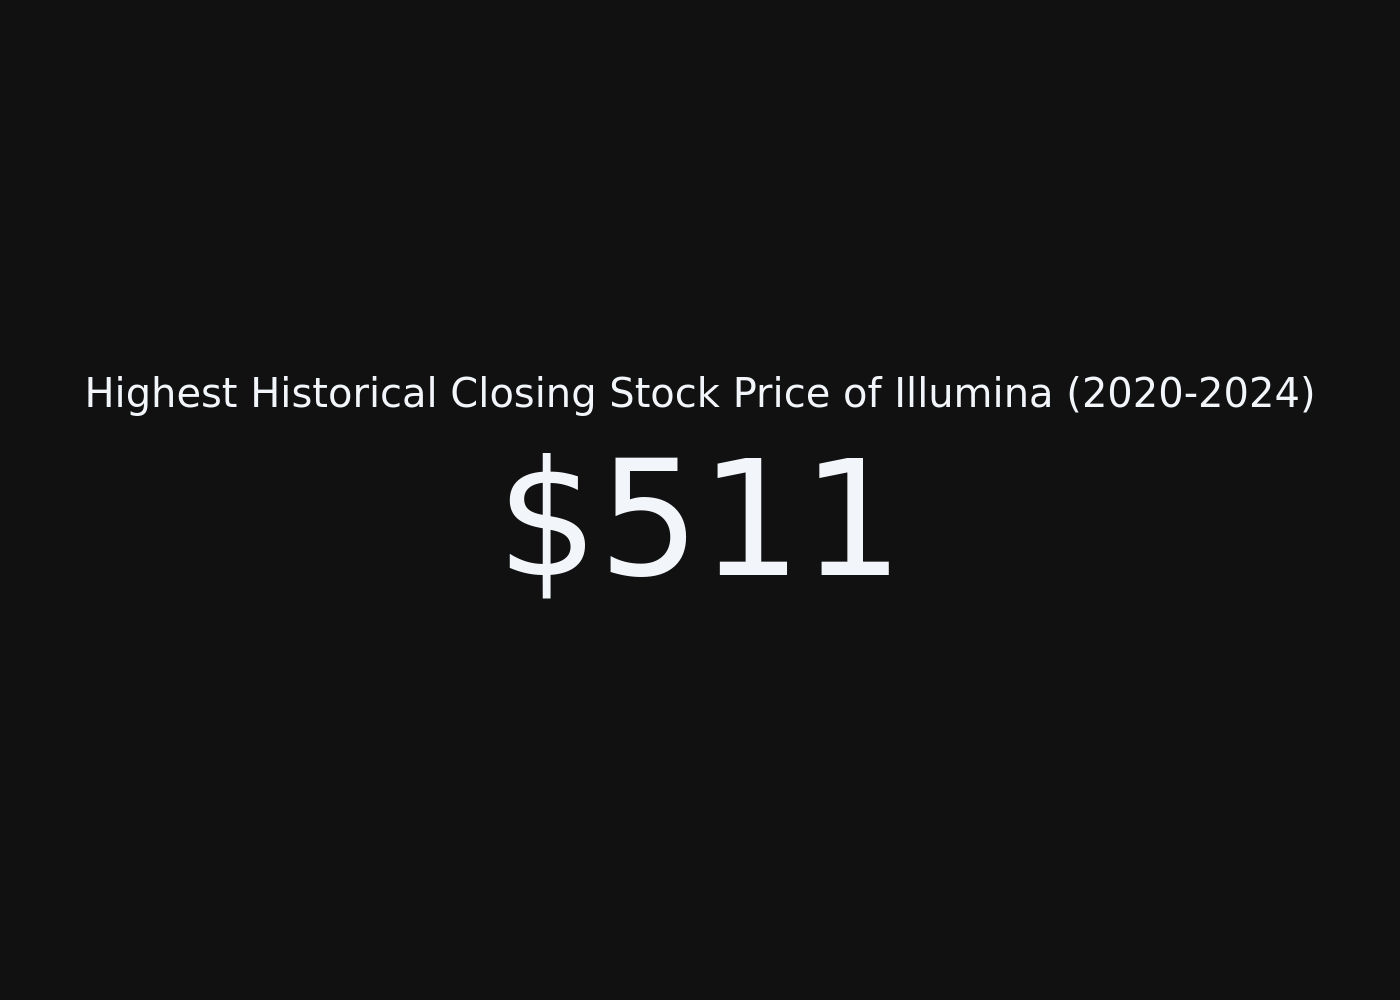

("SELECT date, close \nFROM ilmn \nWHERE date BETWEEN '2020-01-01' AND '2024-12-31' \nORDER BY close DESC \nLIMIT 1;",
                   date       close
 0  2021-08-16 00:00:00  510.544739,
 Figure({
     'data': [{'mode': 'number',
               'number': {'prefix': '$'},
               'title': {'text': 'Highest Historical Closing Stock Price of Illumina (2020-2024)'},
               'type': 'indicator',
               'value': np.float64(510.54473876953125)}],
     'layout': {'template': '...'}
 }))

In [11]:
vn.ask(question="What is the highest historical closing stock price of illumina from 2020-2024, and when did it occur?")